In [28]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn import model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
import cmath
import random

import tensorflow as tf
from tensorflow import keras
import sklearn

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

%matplotlib inline


data = pd.read_csv("qsar_processed.csv")

# Functions

def variance_inflation(df):
    ## Calculate variance inflation factors
    X = df.copy()
    categorical = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    if len(categorical) > 0:
        dummies = pd.get_dummies(X, columns = categorical, drop_first=True)
        cols = dummies.columns
        print("dummies columns: %s" % cols)
        Xc = sm.add_constant(dummies)
        vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
        vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)

        no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
        no_constant['cols'] = cols
        print(no_constant.sort_values(by='VIF', ascending=False))
    else:
        cols = X.columns
        Xc = sm.add_constant(X)
        vifs = [vif(Xc.values, i) for i in range(Xc.shape[1])]
        vifs_ranked = pd.DataFrame(vifs, columns=['VIF'])#.sort_values(by='VIF', ascending=False)

        no_constant = vifs_ranked.drop(0, axis=0).reset_index(drop='index')
        no_constant['cols'] = cols
        print(no_constant.sort_values(by='VIF', ascending=False))
        
        

count    179.000000
mean      -0.611173
std        1.568864
min       -4.000000
25%       -0.925000
50%       -0.040000
75%        0.375000
max        1.470000
Name: y_var, dtype: float64


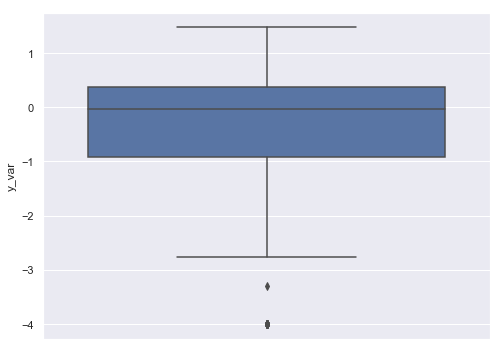

In [29]:
## Target variable analysis
X = data.drop('y_var', axis=1)
y = data['y_var']

print(y.describe())
plt.figure(figsize=(8,6))
g = sns.boxplot(y = data['y_var'])
#g.set_axis_labels("value", "y variable")
plt.show()

top10 = data.sort_values(by='y_var', ascending=False).head(10)
y_range = max(y) - min(y)
bins = np.arange(min(y), max(y), step=0.5)
# top10.plot(kind='hist', bins=bins)
# plt.show()


['nRings7', 'MDEO.22', 'WTPT.3', 'MW', 'nSmallRings', 'BCUTc.1l', 'khs.ssCH2', 'Wlambda2.unity', 'XLogP', 'ATSc5']


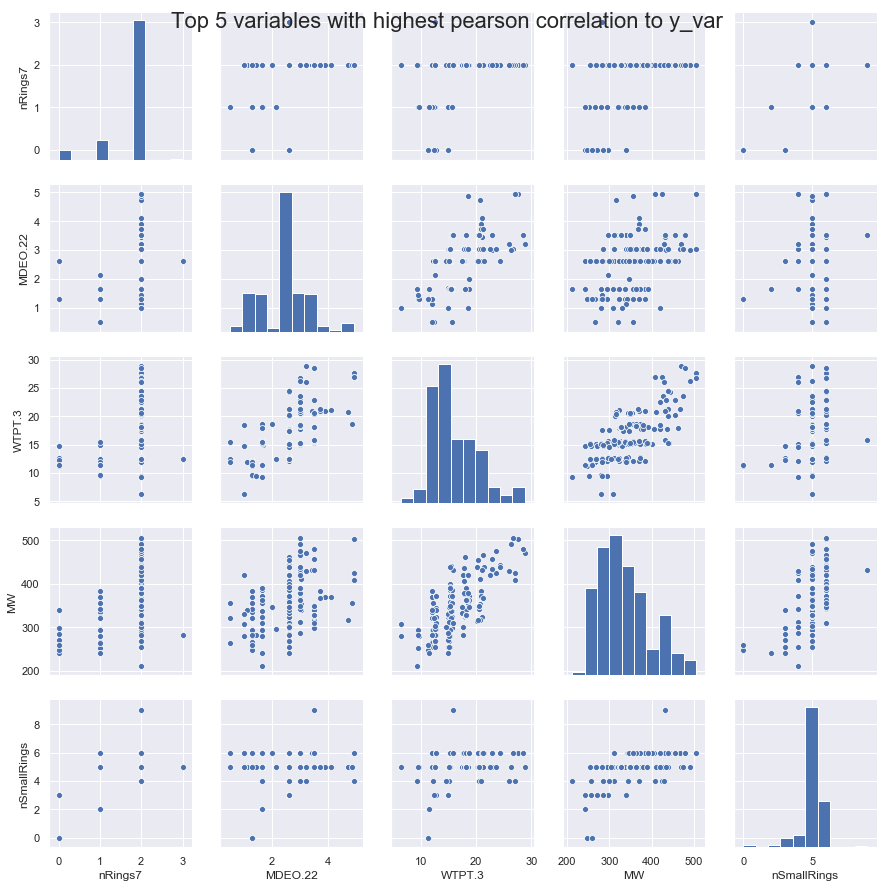

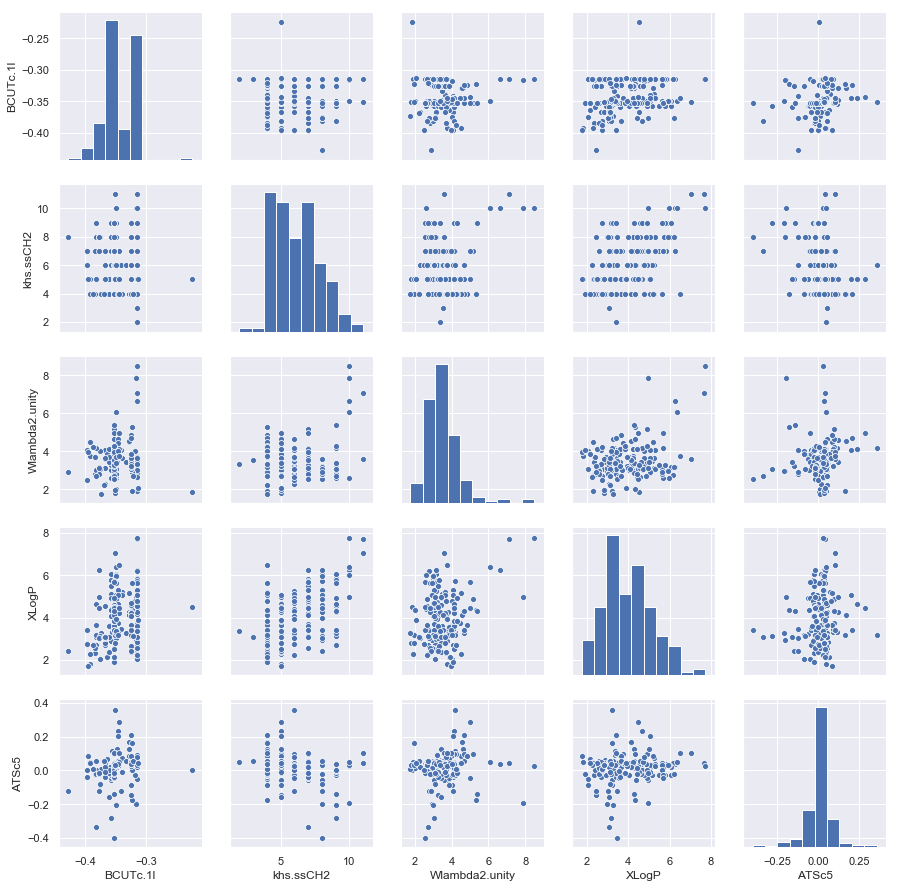

In [30]:
## Feature Analysis
#print(data.columns)
sns.set()

X = data.drop('y_var', axis=1)
y = data['y_var']

## Feature distributions 
# feature_length = X.shape[1]
# for feature in range(0, feature_length):
#     sns.pairplot(data[, size=7, aspect=0.7)
#     plt.suptitle('Feature distributions', size = 22)
#     plt.show()

## Correlation with y-variable - pearson

corr_matrix = X.corrwith(y, axis=0, drop=False, method='pearson').sort_values(ascending=False).head(10)
features = corr_matrix.index.values.tolist()
print(features)

## Feature distributions of top correlated variables
sns.pairplot(data[features[:5]])
plt.suptitle('Top 5 variables with highest pearson correlation to y_var',
             size = 22)
sns.pairplot(data[features[5:]])
plt.show()


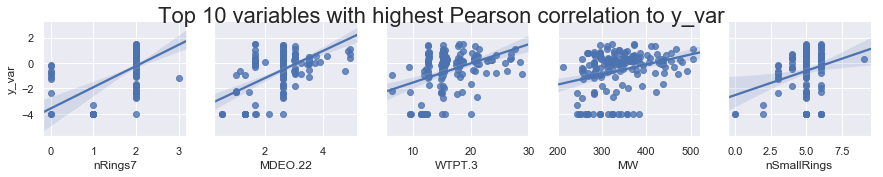

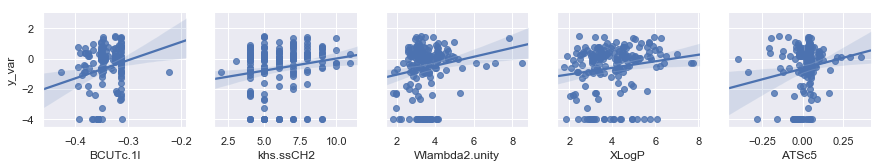

            VIF              cols
62          inf       Weta1.unity
65          inf          WD.unity
63          inf       Weta2.unity
64          inf       Weta3.unity
1   1026.180417                MW
13   480.142052            WTPT.3
9    266.547471       nSmallRings
3    225.621114             nRotB
40   208.367102            khs.dO
14   204.734553            WTPT.5
50   202.397055              SC.3
53   178.948696             SCH.6
12   166.188631    tpsaEfficiency
10   101.868431           nRings5
39    93.338155           khs.sOH
38    90.760042          khs.sssN
49    88.016855               FMF
21    87.691590           MDEC.33
26    86.542155           MDEO.22
22    83.358661           MDEC.34
25    76.226265           MDEO.12
30    68.696202         khs.ssCH2
68    65.554363          BCUTc.1h
61    63.954578        Wnu1.unity
59    61.696770    Wlambda1.unity
72    61.181065              RPCG
51    60.428368              SC.4
0     57.341719             XLogP
19    49.92619

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [31]:

#sns.pairplot(data, x_vars=['XLogP','MW','nRotB'], y_vars='y_var', size=7, aspect=0.7, kind='reg')
#plt.title("Top 10 variables with highest correlation to y_var")
sns.pairplot(data, x_vars=features[:5], y_vars='y_var', kind='reg')
plt.suptitle('Top 10 variables with highest Pearson correlation to y_var',
             size = 22)
sns.pairplot(data, x_vars=features[5:], y_vars='y_var', kind='reg')
plt.show()

## Correlation with y-variable - spearman

# corr_matrix = X.corrwith(y, axis=0, drop=False, method='spearman').sort_values(ascending=False).head(10)
# features = corr_matrix.index.values.tolist()

# #sns.pairplot(data, x_vars=['XLogP','MW','nRotB'], y_vars='y_var', size=7, aspect=0.7, kind='reg')
# #plt.title("Top 10 variables with highest correlation to y_var")
# sns.pairplot(data, x_vars=features[:5], y_vars='y_var', kind='reg')
# plt.suptitle('Top 10 variables with highest spearman correlation to y_var',
#              size = 22)
# sns.pairplot(data, x_vars=features[5:], y_vars='y_var', kind='reg')
# plt.show()



variance_inflation(X)

In [32]:
# Feature set should include all columns except for the label y 
y = data['y_var']
X = data.drop('y_var', axis=1)

## Train and test set split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train columns: ", X_train.columns)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test", y_test.shape)


X_train columns:  Index(['XLogP', 'MW', 'LipinskiFailures', 'nRotB', 'nAtomLAC', 'nAtomP',
       'nBase', 'ALogP', 'nAcid', 'nSmallRings', 'nRings5', 'nRings7',
       'tpsaEfficiency', 'WTPT.3', 'WTPT.5', 'topoShape', 'geomShape',
       'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.24', 'MDEC.33', 'MDEC.34',
       'MDEC.44', 'MDEO.11', 'MDEO.12', 'MDEO.22', 'MDEN.22', 'MDEN.23',
       'khs.dCH2', 'khs.ssCH2', 'khs.dsCH', 'khs.dssC', 'khs.aaaC', 'khs.sNH2',
       'khs.ssNH', 'khs.dsN', 'khs.aaN', 'khs.sssN', 'khs.sOH', 'khs.dO',
       'khs.aaO', 'khs.sF', 'khs.dsssP', 'khs.dS', 'khs.aaS', 'khs.ddssS',
       'khs.sCl', 'khs.sBr', 'FMF', 'SC.3', 'SC.4', 'SC.6', 'SCH.6', 'C1SP2',
       'C1SP3', 'C4SP3', 'ATSc4', 'ATSc5', 'Wlambda1.unity', 'Wlambda2.unity',
       'Wnu1.unity', 'Weta1.unity', 'Weta2.unity', 'Weta3.unity', 'WD.unity',
       'BCUTw.1l', 'BCUTc.1l', 'BCUTc.1h', 'BCUTp.1l', 'PNSA.1', 'PNSA.3',
       'RPCG', 'RPCS', 'RNCS'],
      dtype='object')
X_train:  (143, 75)
X_test: 

Average MSE for linear regression model: 7.730 (+/- -1.000)
Average R2 for linear regression model: -2.095 (+/- 0.746)


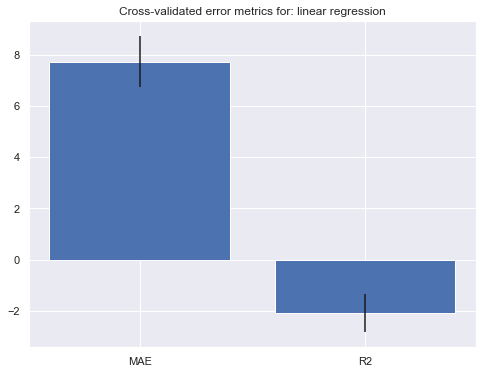

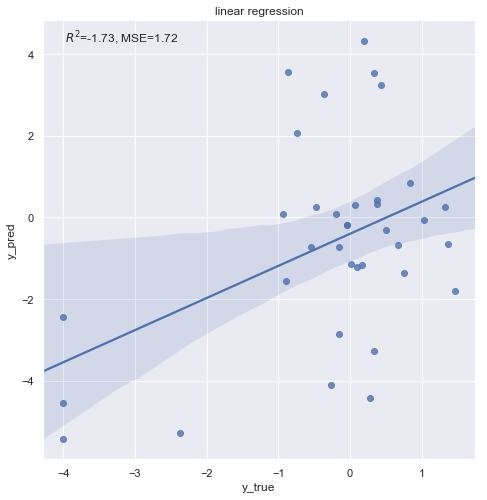

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


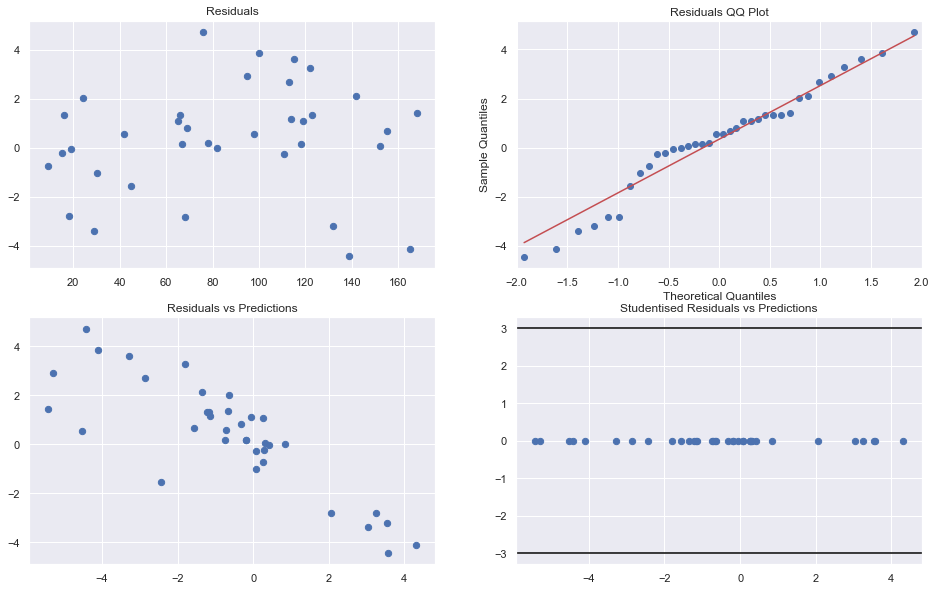

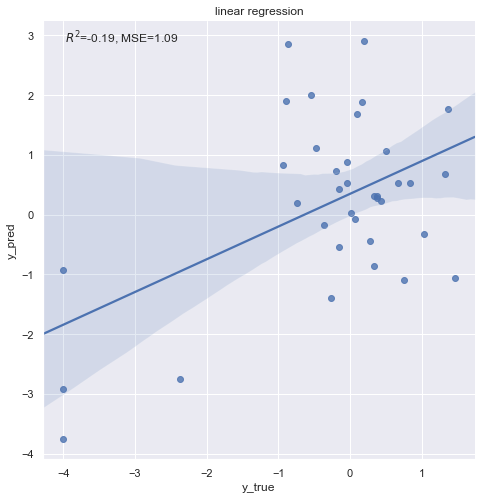

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


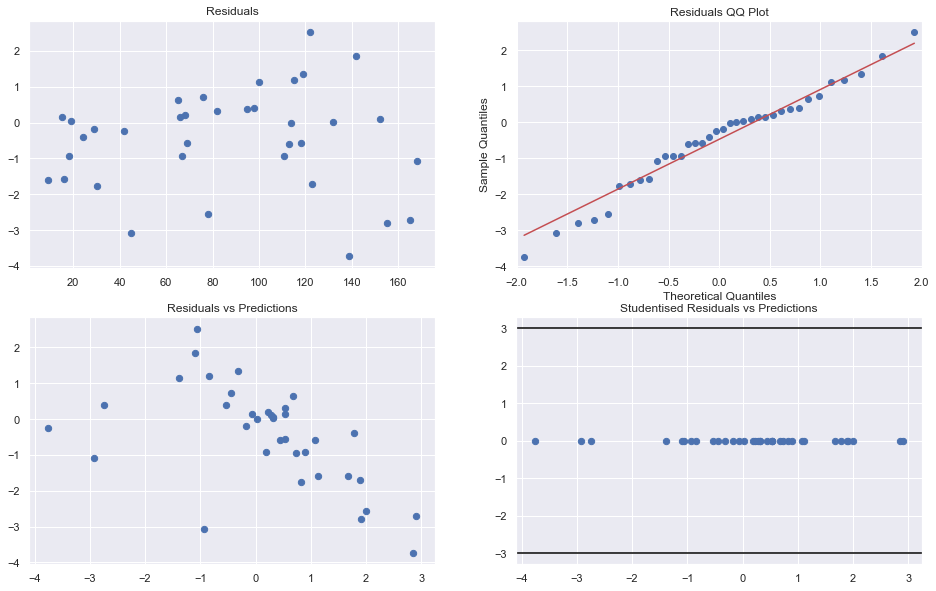

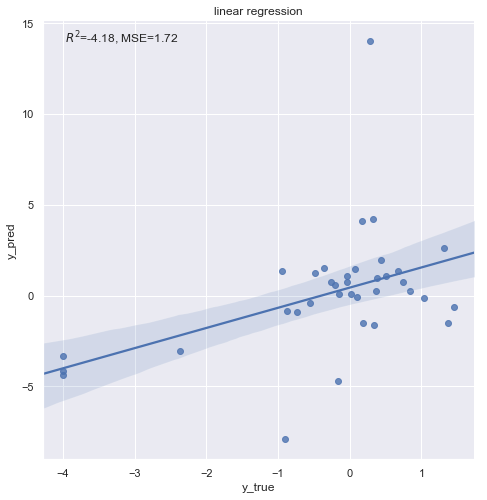

/Users/nathalie.willems/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


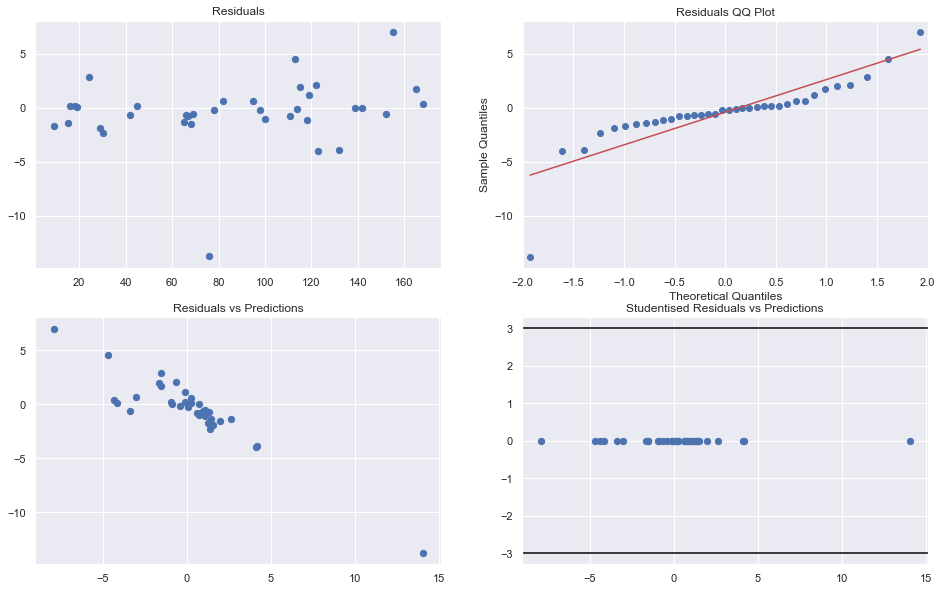

Average MSE for random forest regression model: 0.836 (+/- -0.116)
Average R2 for random forest regression model: 0.670 (+/- 0.057)


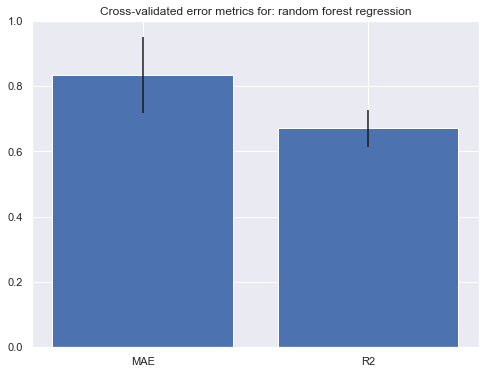

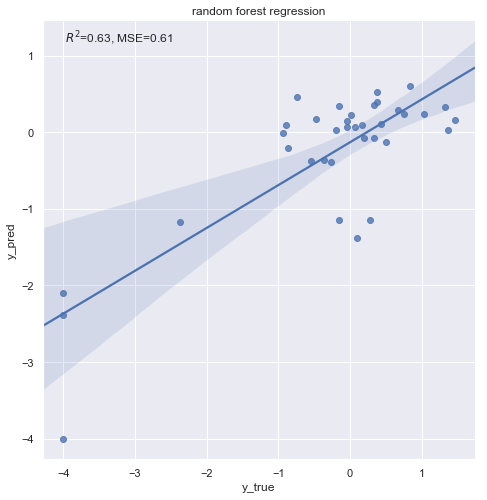

best model: 0 r2 score: 0.63


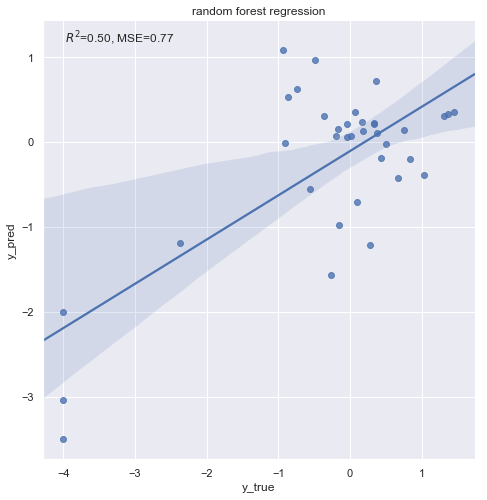

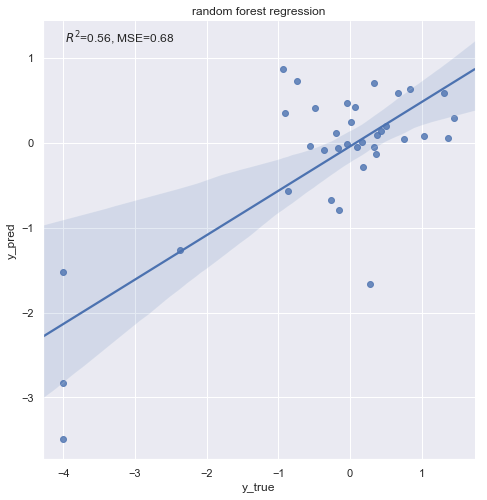

In [33]:
## Preprocessing 

# Normalisations scaling
scaler = preprocessing.StandardScaler()

## Model testing with cross-validation 
linear = linear_model.LinearRegression()
rf = RandomForestRegressor()

## Scoring metrics
metric = ['neg_mean_squared_error', 'r2']

def fit_model(X, y, model, model_name):
    clf = make_pipeline(scaler, model)
    scores = cross_validate(model, X, y, cv=3, scoring=metric, return_train_score=False, return_estimator=True)
    names = ['MAE', 'R2']
    stats = {}
    stats['means'] = [-1 * scores['test_neg_mean_squared_error'].mean(), scores['test_r2'].mean()]
    stats['stds'] = [ -1 * scores['test_neg_mean_squared_error'].std(),scores['test_r2'].std()]
    print("Average MSE for %s model: %0.3f (+/- %0.3f)" % (model_name, stats['means'][0], stats['stds'][0]))
    print("Average R2 for %s model: %0.3f (+/- %0.3f)" % (model_name, stats['means'][1], stats['stds'][1]))
    # ## Error metric plots
    plt.figure(figsize=(8,6))
    plt.title("Cross-validated error metrics for: %s" % model_name)
    plt.bar(names, stats['means'], yerr=stats['stds'])
    plt.show()
    return scores

def plot_residuals(X_train, y_test, pred):
    residuals = y_test - pred
    res_df = pd.DataFrame(residuals)
    res_df.columns = ['residuals']
    res_squared = residuals ** 2
    rss = sum(res_squared)
    n = len(residuals)
    p = X_train.shape[1]
   # denom = 
    #print(rss, n, p, denom)
    rse = cmath.sqrt((rss/(n-p-1.0)))

    # studentised residuals
    res_df['studentised_residuals'] = res_df['residuals'] / rse

    fig, ax = plt.subplots(2,2, figsize=(16,10))
    ax[0,0].scatter(x=res_df.index.values, y=res_df['residuals'], s=40)
    ax[0,0].set_title("Residuals")
    sm.qqplot(residuals, line='s', ax=ax[0,1])
    ax[0,1].set_title("Residuals QQ Plot")
    ax[1,0].scatter(pred, res_df['residuals'], s=40)
    ax[1,0].set_title("Residuals vs Predictions")
    ax[1,1].scatter(pred,res_df['studentised_residuals'], s=40)
    ax[1,1].set_title("Studentised Residuals vs Predictions")
    ax[1,1].axhline(y=3, c='black')
    ax[1,1].axhline(y=-3, c='black')
    plt.show()
    
def evaluate_models(scores, X_test, y_test, name, return_best_estimator=True):
    best_r2 = 0
    best_mae = 0
    best_model = None
    for i in range(len(scores['estimator'])):
        model = scores['estimator'][i]
        pred = model.predict(X_test)
        test = pd.DataFrame(pred, columns=['y_pred'])
        test['y_true'] = y_test.reset_index()['y_var']
        sns.pairplot(test, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
        plt.title(name)
        plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, pred), metrics.mean_absolute_error(y_test, pred)), xy=(0.05, 0.95), xycoords='axes fraction')
        plt.show()
        r2 = metrics.r2_score(y_test, pred)
        if name == 'linear regression':
            plot_residuals(X_test, y_test, pred)
        if r2 > best_r2:
            best_r2  = r2
            best_model = model
            print("best model: %s r2 score: %0.2f" % (i, best_r2))
    return best_model


lin_scores = fit_model(X_train, y_train, linear, 'linear regression')
lin_best = evaluate_models(lin_scores, X_test, y_test, 'linear regression')

rf_scores = fit_model(X_train, y_train, rf, 'random forest regression')
rf_best = evaluate_models(rf_scores, X_test, y_test, 'random forest regression')



## Random Forest Model Analysis

[4.77327022e-03 1.66171586e-02 4.32291852e-05 1.25203501e-03
 8.12202410e-05 4.91578458e-06 0.00000000e+00 8.20339661e-03
 8.00166555e-07 4.44455892e-05]


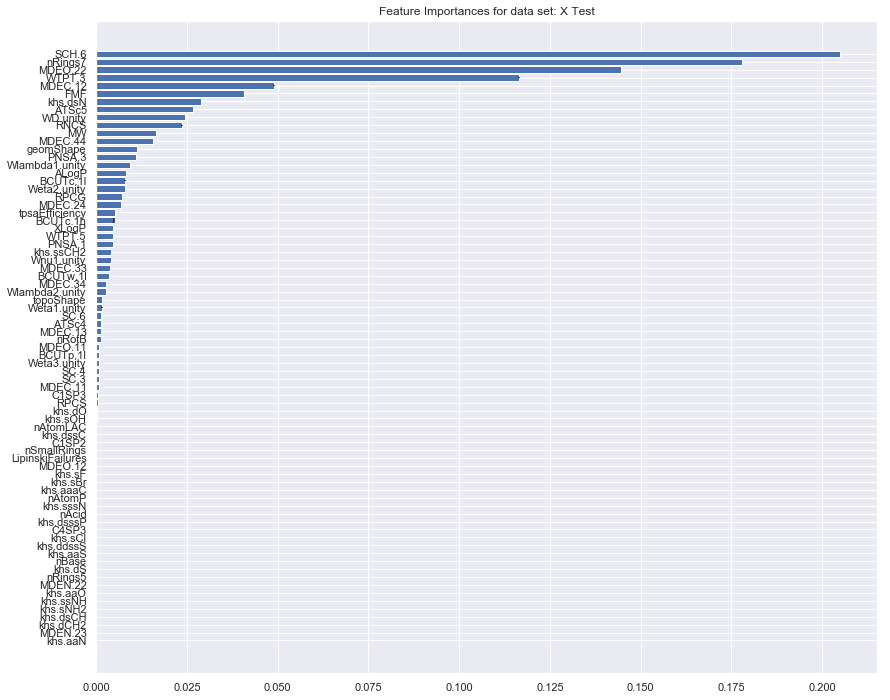

In [34]:
## Feature importance 

def rf_feature_importance(data, model, X, name):
    n_col = data.shape[1]
    features = data.columns[0:n_col]
    pred = model.predict(X)
    #m=RandomForestRegressor(n_estimators=50, oob_score=True,n_jobs=-1,bootstrap=True,random_state=42)
    rank = model.feature_importances_
    indices = np.argsort(model.feature_importances_)
    #print(indices[:10])
    top = rank[indices][:10]
    print(rank[:10])
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    plt.figure(figsize=(14,12))
    plt.barh(range(len(indices)), rank[indices], align='center', yerr=std)
    plt.yticks(range(len(indices)), features[indices])
    plt.title('Feature Importances for data set: %s' % name)
    return rank, indices
    
df = pd.DataFrame(data)
rank, indices = rf_feature_importance(df, rf_best, X_test, "X Test")
#print("ranked: %s" % (rank[indices][:10]))

In [35]:
rf_best.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [36]:
from sklearn.model_selection import GridSearchCV

## Grid search of RF model parameters

## Random Forest parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,5,6,7, 8]

}

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_r2'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_r2'][candidate],
                  results['std_test_r2'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Define scoring metrics

metric = ['neg_mean_squared_error', 'r2']

# Create a regressor object with the regressor and parameter candidates
clf = GridSearchCV(estimator=rf_best, param_grid=param_grid, n_jobs=-1, cv=3, iid=False, scoring=metric, refit='r2')

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)
non_nested_scores = clf.best_score_

# Nested CV with parameter optimization
nested_scores = cross_val_score(clf, X=X_train, y=y_train, cv=3, scoring='r2')
score_difference = non_nested_scores - nested_scores

results = clf.cv_results_
#%%
print("Best parameters set found on training set:")
print()
print(report(results))
print()
print("nested scores: ", nested_scores)
print("non_nested_scores: ", non_nested_scores)
print("score difference: ", score_difference)

Best parameters set found on training set:

Model with rank: 1
Mean validation score: 0.744 (std: 0.025)
Parameters: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.744 (std: 0.030)
Parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.743 (std: 0.024)
Parameters: {'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}

None

nested scores:  [0.70138775 0.77679062 0.69481215]
non_nested_scores:  0.7444453183364192
score difference:  [ 0.04305757 -0.0323453   0.04963317]


## Neural Network Models

### !! This section is not complete and needs more development/testing!!


In [41]:
# Initial hyperparameters were inspired by 
# "Development of QSAR models to predict and interpret the biological activity of artemisinin analogues"

# Best architecture: 10-5-1
# Sigmoid activation function 

def build_model_1(activation):
    model = tf.keras.Sequential([
    keras.layers.Dense(10, activation=activation, input_shape=(75,)),
    keras.layers.Dense(5, activation=activation),
    keras.layers.Dense(1)])
    # Configure a model for mean-squared error regression.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = tf.keras.optimizers.SGD(0.01)
    #optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def build_model_2(activation):
    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 10 units to the model:
    keras.layers.Dense(30, activation=activation, input_shape=(75,)),
    keras.layers.Dense(30, activation=activation),
    keras.layers.Dense(1)])
    # Configure a model for mean-squared error regression.
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    #optimizer = tf.keras.optimizers.SGD(0.01)
    #optimizer = tf.keras.optimizers.Adam(0.01)
    model.compile(optimizer=optimizer,
                  loss='mse',       # mean squared error
                  metrics=['mae', 'mse'])  # mean absolute error
    return model

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

def fit_model(activations, model_func, X_train, y_train):
    models = {}
    for act in activations:
        print("activation function: %s, model type: " % act)
        keras_model = model_func(act)

        # The patience parameter is the amount of epochs to check for improvement
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

        history = keras_model.fit(X_train, y_train, validation_split = 0.2, epochs=100, 
                            callbacks=[early_stop], batch_size=10, verbose=0)

        models[act] = keras_model
        plot_history(history, act)
        
        # Test
        loss, mae, mse = keras_model.evaluate(X_test_scaled, y_test, verbose=0)

        print("Testing set Mean Abs Error: {:5.2f} -Log RA".format(mae))
#         hist = pd.DataFrame(history.history)
#         hist['epoch'] = history.epoch
#         hist.tail()
    return models
    
def model_predict(model, X_test, y_test):
    # Predict
    predictions = model.predict(X_test)

    pred_scores = model.evaluate(X_test, y_test)
    print('Test loss:', pred_scores[0])
    print('Test accuracy:', pred_scores[1])

    results = pd.DataFrame(predictions, columns = ['y_pred'])
    #print(results, y_test)
    #results.columns = ['y_pred']
    results['y_true'] = y_test.reset_index()['y_var']
    sns.pairplot(results, x_vars='y_true', y_vars='y_pred', height=7, aspect=1, kind='reg')
    plt.title("Neural network model")
    plt.annotate('$R^2$=%.2f, MSE=%.2f' % (metrics.r2_score(y_test, predictions), metrics.mean_absolute_error(y_test, predictions)), xy=(0.05, 0.95), xycoords='axes fraction')
    plt.show()

    print("prediction dataframe: \n", results.head(4))
    error = abs(results['y_true'] - results['y_pred'])
    plt.figure(figsize=(8,6))
    plt.hist(error, bins=5)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    plt.show()

---------------
Model 1: 10-5-1
---------------
activation function: sigmoid, model type: 


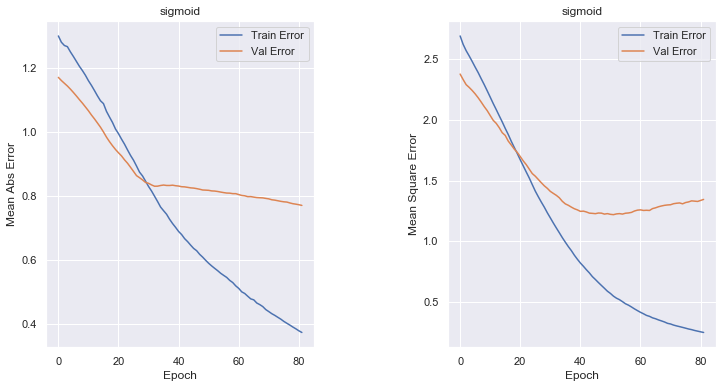

Testing set Mean Abs Error:  0.89 -Log RA
activation function: relu, model type: 


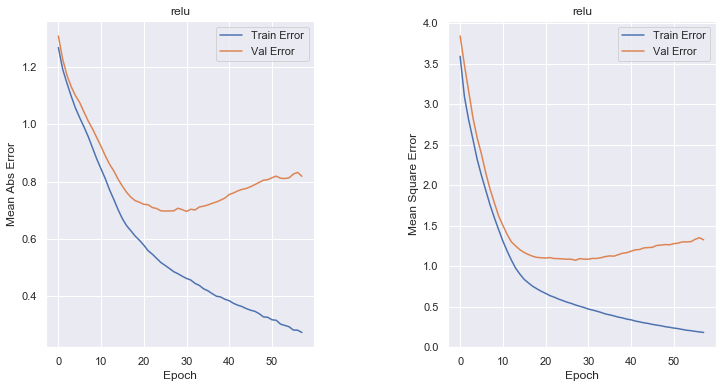

Testing set Mean Abs Error:  0.94 -Log RA
---------------
Model 2: 30-30-1
---------------
activation function: sigmoid, model type: 


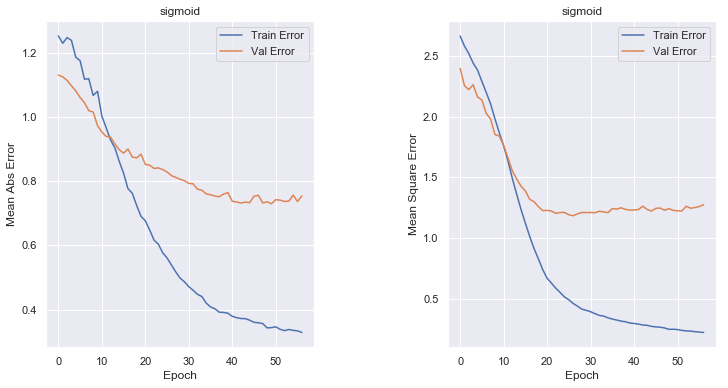

Testing set Mean Abs Error:  0.86 -Log RA
activation function: relu, model type: 


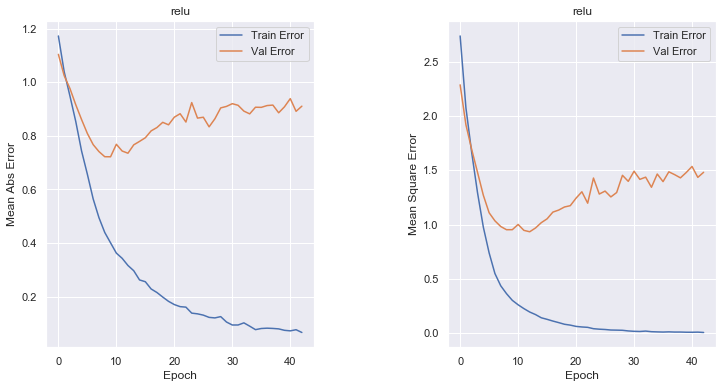

Testing set Mean Abs Error:  0.79 -Log RA


In [44]:
activation_functions = ['sigmoid', 'relu']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("---------------")
print("Model 1: 10-5-1")
print("---------------")
models_1 = fit_model(activation_functions, build_model_1, X_train_scaled, y_train)
print("---------------")
print("Model 2: 30-30-1")
print("---------------")
models_2 = fit_model(activation_functions, build_model_2, X_train_scaled, y_train)

---Prediction----
36/36 [==============================] - 0s 74us/sample - loss: 0.9795 - mean_absolute_error: 0.7320 - mean_squared_error: 0.9795
Test loss: 0.9795004046625562
Test accuracy: 0.731981


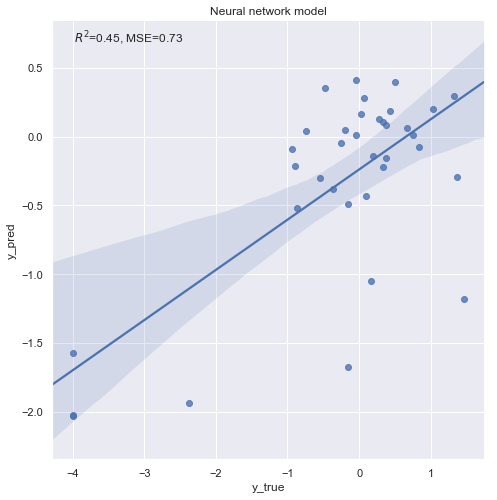

prediction dataframe: 
      y_pred  y_true
0 -0.297229   -0.55
1 -0.434622    0.10
2  0.299140    1.32
3  0.161369    0.02


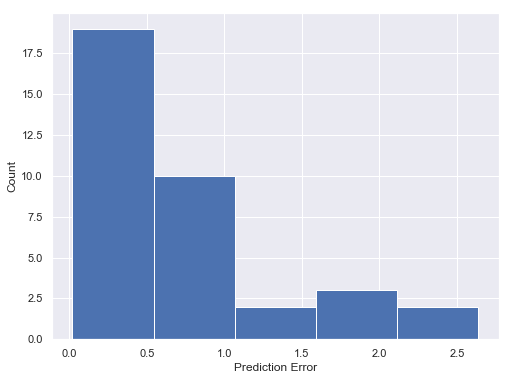

36/36 [==============================] - 0s 60us/sample - loss: 0.9581 - mean_absolute_error: 0.7234 - mean_squared_error: 0.9581
Test loss: 0.9581063191095988
Test accuracy: 0.7234012


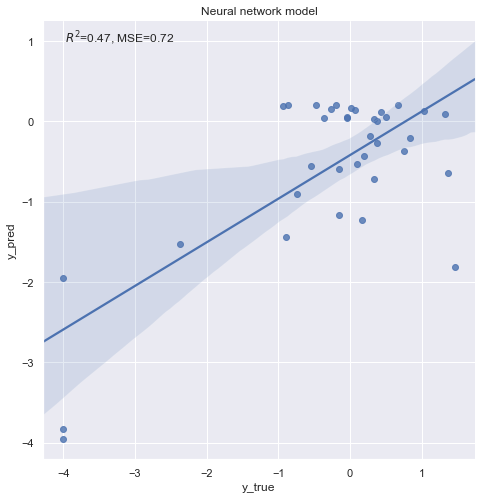

prediction dataframe: 
      y_pred  y_true
0 -0.556159   -0.55
1 -0.524515    0.10
2  0.097462    1.32
3  0.170596    0.02


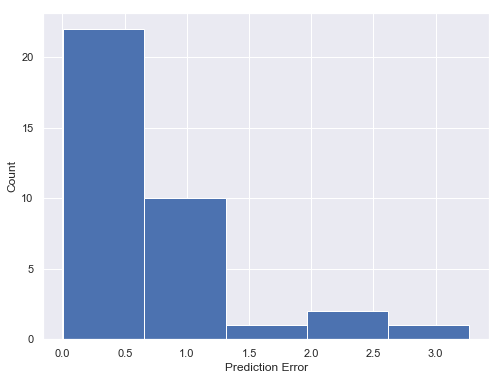

In [20]:
print("---Prediction----")

for m in models_1:
    #print(models[m])
    model_predict(models_1[m], X_test_scaled, y_test)

In [27]:
example_batch = X_train_scaled[:10]
example_result = models_1['sigmoid'].predict(example_batch)
example_result

array([[-1.6937764 ],
       [-1.4271785 ],
       [ 0.14019111],
       [-2.0600002 ],
       [-2.0043669 ],
       [-0.06624839],
       [ 0.05327615],
       [ 0.14529395],
       [-2.0459526 ],
       [ 0.2721492 ]], dtype=float32)